In [1]:
# Imports
import numpy as np, matplotlib.pyplot as plt
import torch, torch_pca, gc
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from PIL import Image
from tqdm import tqdm

In [2]:
# Params
SIDE_LENGTH = 128

In [3]:
# Misc. setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Data imports
train_transforms=transforms.Compose([
    transforms.Resize((SIDE_LENGTH, SIDE_LENGTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.Grayscale(),
    transforms.ToTensor(),])

test_transforms=transforms.Compose([
    transforms.Resize((SIDE_LENGTH, SIDE_LENGTH)),
    #transforms.Grayscale(),
    transforms.ToTensor(),])

try: train_dataset = datasets.Imagenette(transform=train_transforms, size="160px", root='data', split='train', download=True)
except RuntimeError: train_dataset = datasets.Imagenette(transform=train_transforms, size="160px", root='data', split='train')
test_dataset = datasets.Imagenette(transform=test_transforms, size="160px", root='data', split='val')

In [8]:
pcas_raw = torch.load('pcas9469.pt', weights_only=True)

In [47]:
class FakePCA:
    def __init__(self, means, components):
        self.mean_ = means
        self.components_ = components
        self.n_components_ = components.shape[0]
    
    def transform(self, t):
        return torch.matmul(self.components_, t.flatten() - self.mean_.flatten())
    
    def inverse_transform(self, t):
        return torch.matmul(self.components_.transpose(1, 0), t.flatten()) + self.mean_

In [48]:
pcas = [FakePCA(pcas_raw[f"mean{i}"], pcas_raw[f"components{i}"]) for i in range(3)]

In [41]:
def load_test_img(idx: int):
    """Returns the given test image as a torch tensor with shape (s, s, 3)."""
    global test_dataset, device
    return torch.tensor(np.array(test_dataset[idx][0]), dtype=torch.float32).permute(1, 2, 0).to(device)

def pca_project(pcas, idx: int, n=None):
    """Projects the given test image on n PCA components, or all available if `n` is unspecified."""
    global SIDE_LENGTH
    nc = pcas[0].n_components_
    n = nc if n is None else n
    p = torch.cat((torch.ones(n), torch.zeros(nc-n)), dim=0)
    sl = SIDE_LENGTH
    img = load_test_img(idx)
    tchs = [pca.inverse_transform(pca.transform(img[:, :, ch].reshape(1, -1)) * p).reshape(sl, sl, 1) for (ch, pca) in enumerate(pcas)]
    return torch.cat(tchs, dim=2)

def show_img(t):
    return Image.fromarray(torch.clamp(255*t.to("cpu"), 0, 255).byte().numpy())

def show_test_img(idx):
    return Image.fromarray(np.array((255*test_dataset[idx][0]).byte()).transpose((1, 2, 0)))

def normalize_gray(x: torch.Tensor):
    """Normalizes 0 to 0.5, and scales everything evenly so that all elements are in [0, 1].
    (Almost surely) either the smallest element will be 0 or the largest will be 1."""
    return 0.5 + x/(2*torch.max(torch.abs(x)))

def normalize_01(x: torch.Tensor):
    """Normalizes x so that the smallest element is 0 and the largest is 1."""
    return (x-torch.min(x))/(torch.max(x)-torch.min(x))

def get_component(pcas, idx):
    global SIDE_LENGTH
    nc = pcas[0].n_components_
    sl = SIDE_LENGTH
    if idx == -1:
        return torch.cat([(pca.mean_).reshape(sl, sl, 1) for pca in pcas], dim=2)
    p = torch.eye(nc)[idx]
    q = torch.cat([(pca.inverse_transform(p)-pca.mean_).reshape(sl, sl, 1) for pca in pcas], dim=2)
    # Attempt to align the components in sign.
    for ch in [1, 2]:
        flip = torch.sign(torch.dot(q[:, :, 0].flatten(), q[:, :, ch].flatten()))
        assert flip != 0, f"The {idx}th components for channel 0 and {ch} are orthogonal. This is extremely unlikely."
        q[:, :, ch] *= flip
    return q

def pca_multi_project(pcas, idx: int, components_subset=None):
    """Projects the given test image on all PCA components.
    Returns a (nc+1, s, s, 3) tensor with the [0, :, :, :] tensor representing channel-wise means,
    and [n, :, :, :] are projections on the n first components (incl. means)."""
    global SIDE_LENGTH, device
    nc = pcas[0].n_components_
    csl = nc
    sl = SIDE_LENGTH
    img = load_test_img(idx)

    with torch.no_grad():
        # Helper matrix. When BROADCAST-multiplied by x (shape (1, nc)),
        # creates an upper triangular matrix where each column contains the first elements of x
        A = torch.triu(torch.ones(nc, nc), diagonal=0)
        if components_subset is not None:
            A = A[:, components_subset]
            csl = len(components_subset)
        A.to(device)
        # Allocate output
        out = torch.zeros((csl+1, sl, sl, 3))
        # Loop over each channel
        for (ch, pca) in enumerate(pcas):
            # Get the projection on the latent space.
            x = pca.transform(img[:, :, ch].reshape(1, -1)).reshape(-1, 1) # (nc, 1). Has to have this dimension for broadcasting.
            x_mat = A * x # Upper-triangular (nc, nc)-matrix where each column contains the first elements of x
            comps = pca.components_.transpose(0, 1) # The principal components, as a (16384, nc)-matrix
            comp_projs = torch.matmul(comps, x_mat) # Projection on the first principal components. (16384, nc)
            out[1:, :, :, ch] = comp_projs.permute(1, 0).reshape(csl, sl, sl) # Unpack into output
            out[:, :, :, ch] += pca.mean_.reshape(1, sl, sl) # Add the mean to all outputs to complete the projection.
    return out

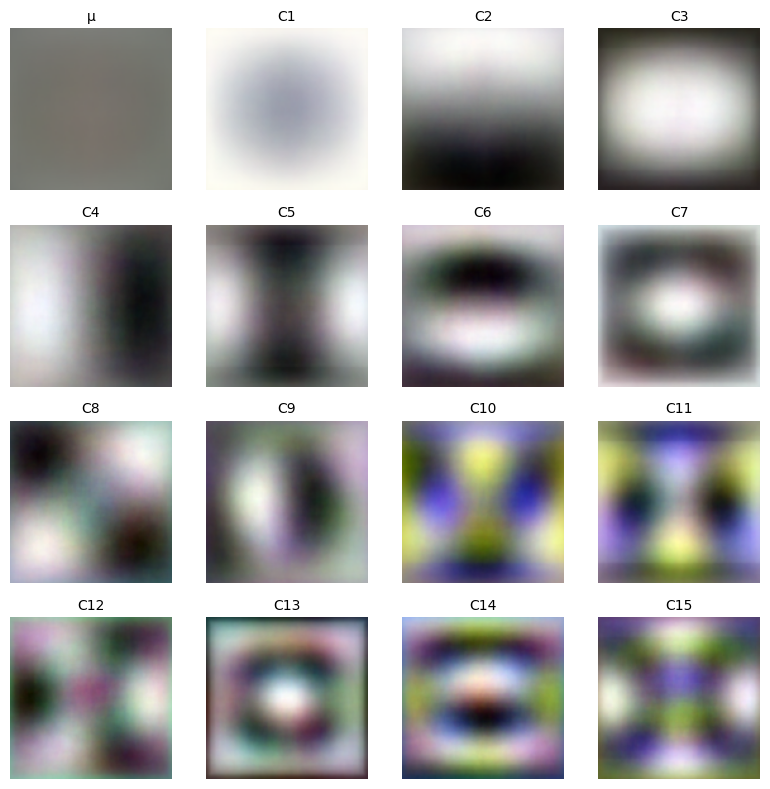

In [42]:
num_rows = 4
num_cols = 4  # Adjust based on how many images you want to plot

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

ax = axes[0,0]
ax.imshow(show_img(get_component(pcas, -1)))
ax.axis('off')
ax.set_title('µ', fontsize=10)

for i in range(num_rows * num_cols-1):
    ax = axes[(i+1) // num_cols, (i+1) % num_cols]
    ax.imshow(show_img(normalize_gray(get_component(pcas, i))))
    ax.axis('off')
    ax.set_title(f'C{i+1}', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

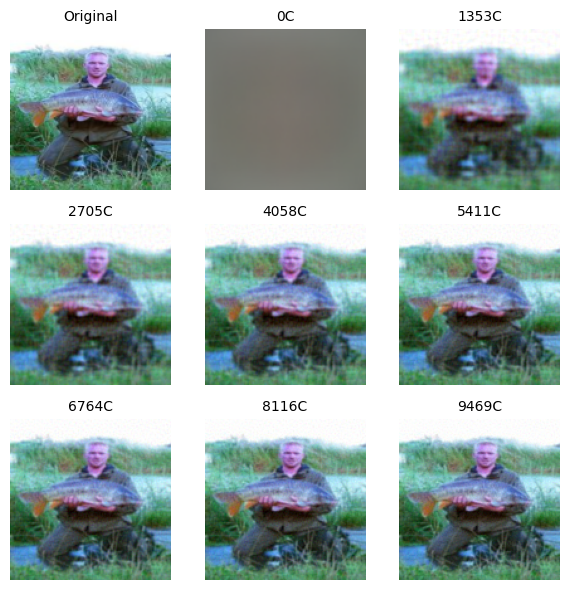

In [49]:
idx = 100
num_rows = 3
num_cols = 3  # Adjust based on how many images you want to plot
nc = pcas[0].n_components_

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))

ax = axes[0,0]
ax.imshow(show_test_img(idx))
ax.axis('off')
ax.set_title('Original', fontsize=10)

for i in range(num_rows*num_cols-1):
    n = round(np.linspace(0, nc, num_rows*num_cols-1)[i])
    ax = axes[(i+1) // num_cols, (i+1) % num_cols]
    ax.imshow(show_img(pca_project(pcas, idx, n=n)))
    ax.axis('off')
    ax.set_title(f'{n}C', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [50]:
# Veeery slow...
l = len(test_dataset)
nc = pcas[0].n_components_

components_subset = [0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095, 8191]
csl = len(components_subset)

mse = np.zeros((l, csl))
ssim = np.zeros((l, csl))
psnr = np.zeros((l, csl))

# This may benefit from parallelization
# For N=100 with step 0, should take just under 1hr.
for i in tqdm(range(l)):
    original = np.array(load_test_img(i)) # (128, 128, 3)
    original_bc = np.broadcast_to(original[None, :, :, :], (csl, *original.shape)) # (nc, 128, 128, 3)
    cprojected = np.array(pca_multi_project(pcas, i, components_subset))[1:, :, :, :] # (nc, 128, 128, 3)
    mse[i, :] = np.mean(np.square(cprojected - original_bc), axis=(1,2,3))
    for n in range(len(components_subset)):
        ssim[i, n] = structural_similarity(original, cprojected[n, :, :, :], data_range=1, channel_axis=2)
        psnr[i, n] = peak_signal_noise_ratio(original, cprojected[n, :, :, :], data_range=1)

  1%|          | 37/3925 [01:20<2:20:35,  2.17s/it]


KeyboardInterrupt: 